# Summary

The **Network Failures - Servicer** scenario group creates a series of environments where service is interrupted in different ways, and evaluates the resilience of the network in coping with (or 'bouncing back' from) the interruption. The scenarios cover a variety of different service interruptions, ranging from a network dropout by region ("Geozone") to shutdowns occurring at different points in time and of a limited or unlimited duration. Different combinations of protocol parameter values generate different simulation outcomes, that are summarized by key peformance indicators (KPIs). The KPIs are then assessed according to desired values (success criteria), using _threshold inequalities_ generated from threshold values for KPIs that meet stakeholder criteria.

Because an exhaustive 'sweep' of every possible combination of relevant protocol parameters is computationally infeasible, this study has instead performed an **adaptive search**, whereby a coarse initial grid of parameters is successively refined by applying the success criteria to generated KPIs, and inferring a new 'direction' of search for a succeeding grid. Convergence is achieved when all success criteria are met across the performed simulations. Although it is always possible that multiple "equilibria" exist, such that success criteria are met by parameter combinations that are not found from adaptive search, the initial grid is informed by existing parameter values from the Pocket network and hence benefit from the expert knowledge used to define those initial values. 

Future work can perform a more thorough search of the underlying parameter space, in addition to performing more demand scenarios and realizations from the exogenous distributions that represent external factors.

# Contents

**Experimental Setup**: This covers the objective of the study and its methodology, describes the KPIs and success indicators (threshold inequalities), the protocol and environmental sweep parameters and their initial ranges, and finally summarizes the computational complexity of the simulations themselves.

**Adaptive Grid Results**: The evolution of the parameter selection process is presented as a visualization, showing the convergence of the protocol parameter ranges as different success criteria are achieved.

**Protocol Parameter Recommendations**: Based upon the adaptive grid results, the recommended parameter ranges are presented.

**Decision Tree and Parameter Importance**: Using the adaptive grid results, a machine-learning process is applied to infer the importance of different parameters on the associated KPI-based threshold inequalities. This provides a method of assessing whether one or more parameters are 'crucial' to success, in the sense that they have an outsized impact on the success criteria. This approach leverages decision trees that are fit to the results of the entire adaptive grid process.

**Parameter Impact on KPIs**: A density approach (histogram) can be used to assess the impact of protocol parameters on the KPIs of the scenario. The KPI densities are shown for each protocol parameter sweep value, providing a visual indication of the impact of the parameter on the density shape and location.

**Conclusion**: An overall assessment of the scenario results is provided, highlighting any problems, caveats, implications and possibilities for future/extended work.


# Experimental Setup

## Objective and Methodology

The objective of the network failures - servicer scenario group is to understand the impact of parts of the servicer network 'going dark' on the ability of the network to reassign relay requests (work).

- **System Goals Targeted**:
  - Service Reliability
  - Accessibility
- **Design**: allow for groups of servicers to be rendered unavailable by 1) 'shutting down' by GeoZone, or 2) 'unlinking' a random service from the network, for a limited or unlimited period of time
- **Testing Variables**:
  - Environmental:
      - Introduce different starting network densities, defined as the fraction of actual servicer-to-service connections to the total number possible of such connections. A _sparse_ network may be less resilient as there are fewer paths to route relay requests to services, while a _dense_ network may be more resilient, but potentially less profitable for individual servicers if their service connections are too 'diffuse'.
      - Introduce an interruption event--for this scenario, events are divided between those which interrupt servicers based upon a servicer attribute, and those which interrupt services for a random duration.
          - For the servicer interruption, currently only the "Geozone" attribute is available. Halfway through a simulation, a particular Geozone is selected at random and all servicers matching the selected Geozone are 'taken offline' for the remainder of the simulation, severing connections to both applications/gateways and services.
          - For the service interruption, there are different interruption durations selected. Halfway through a simulation a randomly-selected service is 'dropped' from the network for a particular duration, and then comes back 'online' for the remainder of the simulation after the specified service interruption duration.
  - Protocol:
      - Assess the impact of different `SlashFractionDowntime` (SFD) values. The SFD is the fraction of a servicer's stake that is slashed (burnt) when a servicer is 'down' (including when it is jailed, or omitted from the network, as here). It is assessed at each timestep of the simulation (each day) that a servicer is considered 'down'.
      - Assess the impact of different `MaxChainsPerServicer` (MCPS) values. The higher the number of services ('chains', in earlier parlance) that can connect to a servicer, the more potential redundant pathways exist for a relay request to traverse, which can increase resiliency. On the other hand, there are additional complexity and running costs that a servicer must consider when connecting to more than one service.


**Note**: The protocol parameter `DowntimeJailDuration` (DJD) was originally intended to be assessed in this scenario, being the minimum 'lockout' time before a jailed/offline servicer can unjail and re-join the network. However, the simulation environment resolves to daily resolution, which is far longer than the _a priori_ default length of time (1 hour) this parameter has. Thus, to be effective sweep values of at least one day would be needed, as well as an impact scenario of this parameter on jailing/unjailing behavior. After review it was determined that assessing network resiliency would not require a minimum downtime, leaving this parameter value to be determined in conjunction with e.g. "Fisher" behavior when added to the model.

## KPIs

- Servicer slashing cost (KPI-8): This measures the total slashing costs a servicer experiences over the simulation.
- Servicer jailing opportunity cost (KPI-11): This measures the block reward that servicers missed while being jailed/down, relative to the total block reward they received over the simulation.
- Network load balancing (KPI-C): The main KPI for this scenario group. Network load balancing is a measure of the distribution of relays served over the network, with a more equal distribution reflected in a KPI value of zero, and a perfectly unequal distribution (i.e. all relays through one servicer) reflected in a value of one. This KPI is measured at two points in time: immediately preceding a network interruption, to reflect the state of the network's load balancing under 'normal operating conditions', and at the end of the simulation, to reflect the state of load balancing after the interruption has concluded.

## Threshold Inequalities

1. (**Servicer Slashing Cost**) The fraction of the Monte Carlo simulations for which the average servicer slashing cost for an interruption by attribute (such as Geozone) exceeds $1$ POKT should be less than $10$%. This inequality restriction is referenced in the code as `servicer_slashing_cost_success`.
2. (**Servicer Jailing Opportunity Cost**) The fraction of the Monte Carlo simulations for which the servicer jailing opportunity cost for an interruption by attribute (such as Geozone) exceeds $1$ POKT should be less than $10$%. This inequality restriction is referenced in the code as `servicer_jailing_cost_success`.
3. (**Network Load Balancing**) The fraction of the Monte Carlo simulations for which the average network load balance recovers to within $0.8$ (as a fraction) of the initial network load balance before interruption should be at least $90$%. This inequality restriction is referenced in the code as `network_load_balancing_success`.

## Sweep Parameters

### Swept Protocol Parameters

1. `SlashFractionDowntime` (`SFD`)
2. `MaxChainsPerServicer` (`MCS`)

### Swept Environmental Parameters

1. Servicer-to-service initial network density parameter, `servicer_service_density_starting`. Sweeping this parameter initializes the network density at different levels, ranging from sparse to dense.
2. Event selection:
   - Attribute to condition upon for shutdown, `servicer_shutdown_by_geozone_random`. Sweeping this parameter shuts down servicers across the Geozone region specified.
   - Duration of a service (chain) outage, `service_shutdown_random`. Sweeping this parameter represents different interruption event durations of a certain number of days.

## Initial Parameter Sweep Ranges

Protocol and Environmental parameters were initialized for the first adaptive grid search according to:
1. Values found in the specifications provided to BlockScience ([V1 Mechanism spreadsheet](https://docs.google.com/spreadsheets/d/1Gpnw3ZXNh9lWFgmrbrg8wTqVKPD2M8QqJdAiAALru38/edit?usp=sharing), [V1 Minting spreadsheet](https://docs.google.com/spreadsheets/d/1QYe6NzuiyimsXs5cT1BSM-UT1DtX_K38cOZsEFJOtdA/edit?usp=sharing)),
2. Discussions with the Pocket team, and
3. BlockScience best practice. 

### Environmental Parameters

| Full Name |  Sweep Variable Name | Sweep Values | Units |
| --- | --- | ---| ---|
| Servicer-to-service initial network density | `servicer_service_density_starting`  | (0.1, 0.5, 1.) | %/100 |
| Attribute to condition upon for shutdown  | `servicer_shutdown_by_geozone_random` | 'Geozone' | String |
| Duration of a service (chain) outage | `service_shutdown_random`  | (1, 7, 500) | Days |

### Protocol Parameters

| Full Name |  Sweep Variable Name | Sweep Values | Units |
| --- | --- | ---| ---|
| `SlashFractionDowntime` | `slash_fraction_downtime` | (1e-10, 1e-1) | %/100 |
| `MaxChainsPerServicer` | `max_chains_servicer` | (1, 20) | Number |

## Computational Complexity

**Total number of parameter constellations**: 48

**Total number of Monte Carlo runs per constellation**: 5

**Total number of experiments per adaptive grid**: 240

**Number of adaptive grid searches**: 6

**Total number of parameter constellations evaluated**: 1,440

# Adaptive Grid Results

In [1]:
import os
os.chdir("..")
from psuu import load_all_kpi_comparison_data, load_scenario_kpi_comparison_data, threshold_comparison_plot, decision_tree_feature_importance_plot

KPIs are referenced as:
servicer_slashing_cost_success: 1
servicer_jailing_cost_success: 2
network_load_balancing_success: 3


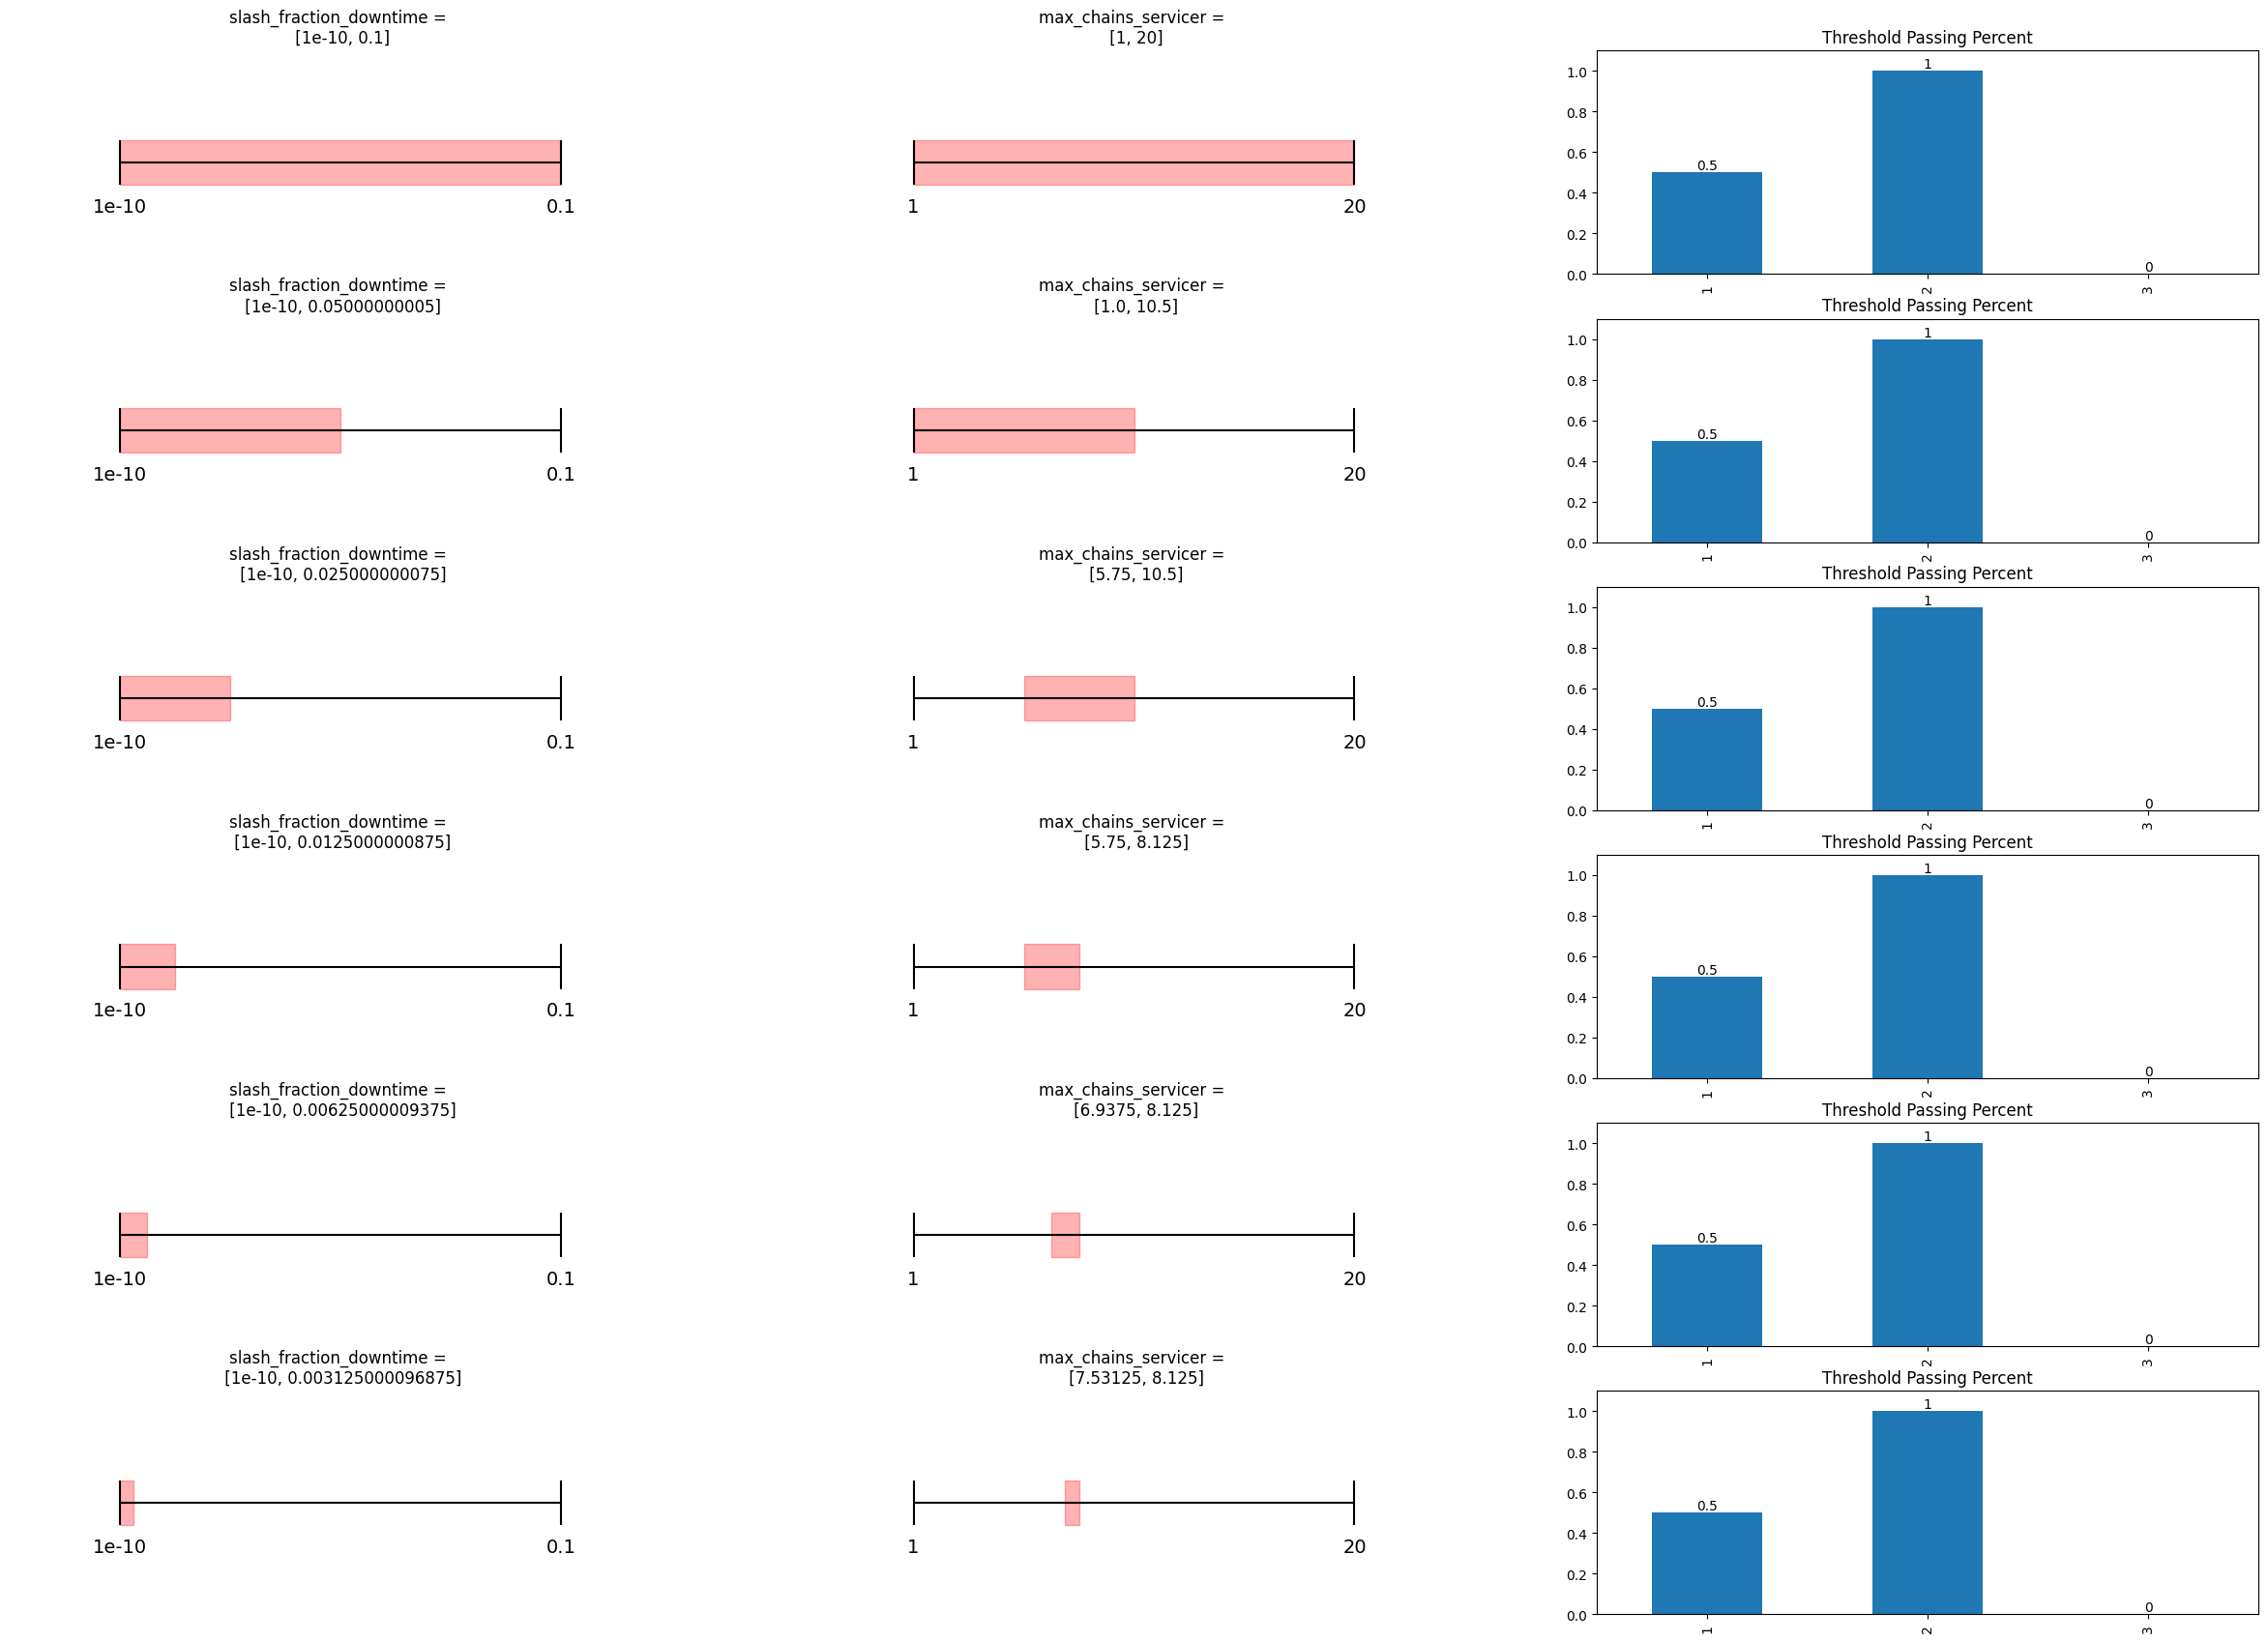

In [2]:
scenario_sweep_category = 'network_failures_service_ag'
kpis = load_scenario_kpi_comparison_data(scenario_sweep_category)
threshold_comparison_plot(kpis[scenario_sweep_category])

# Protocol Parameter Recommendations

From the adaptive grid results, the recommended parameter ranges for the swept protocol parameters are:

| Full Name |  Abbreviation | Recommended Range | Units |
| --- | --- | ---| ---|
| `SlashFractionDowntime` | `slash_fraction_downtime` | (1e-10, 3.125e-3) | %/100 |
| `MaxChainsPerServicer` | `max_chains_servicer` | (7.53125, 8.125) | Number |
<A list of table entries corresponding to the final ranges for the protocol parameters is given here.>

# Decision Tree and Parameter Importance

## Decision Tree Classification

A decision tree is a machine-learning-based classifier. Given the simulation results, for each threshold inequality the tree recursively associates different _samples_ from the results, according to sorting criteria based upon one or more of the protocol parameters of the simulation.

Each decision tree below corresponds to one of the threshold inequalities stated above. Where the decision tree is 'empty', the threshold inequality was either 1) always fulfilled during the simulations, or 2) never fulfilled during the simulations. In this case no sensitivity analysis can be performed, as the threshold inequalities do not vary according to the different parameter combinations that were swept.

The title of the decision tree includes the threshold inequality under scrutiny, in addition to a technical 'score' (usually "100%") and the number of simulation results used as the dataset. Within the decision tree presented, each **non-terminal** 'node' is labeled with the following information:

1. The sorting variable used and its cutoff value used for classification, in the form of `parameter_name <= x` where `x` is the cutoff value. Branches to the left of this node indicate satisfaction of this inequality, while branches to the right indicate violations, i.e. `parameter_name > x`.
2. A Gini coefficient representing the method of recursive association used.
3. The total number of simulation results ("samples = y%") as a percentage "y" that are considered at this node.
4. The breakdown of the simulation results considered into the left and right branches ("value = [p, 1-p]"), where "p" is the fraction of results that satisfy the `parameter_name = x` constraint, and "1-p" the fraction satisfying `parameter_name > x`.
5. The classification of the majority of the simulation results at this node (note that this is not a final classification, as it appears in a non-terminal node, and can be arbitrary if the results are split equally across classes).

**Terminal** nodes ("leaves") represent the final classification of that proportion of the simulation results that arrive at the node, and have most of the same information as a non-terminal node, with the exception that there is no branching performed and hence no sorting variable displayed. Here the most important information is the classification (last line). 

Non-terminal and terminal nodes colored in blue correspond to the threshold inequality being met, and by following blue boxes from a terminal node up to the root of tree a set of `parameter_name <= x` and/or `parameter_name > x` sorting criteria can be chained together. 

Upon successful classification, it is usual for the terminal node to have a breakdown "value = [1.0, 0.0]" or "value = [0.0, 1.0]", indicating that 100% of the remaining simulation results treated are either satisfying the threshold inequality under treatment (left value is 1.0), or not satisfying the threshold inequality (right value is 1.0).

For further information regarding the decision tree approach adopted here please see the [Decision Trees](https://scikit-learn.org/stable/modules/tree.html#) documentation from the `scikit-learn` library.

## Feature Importance

Below each non-empty decision tree is a bar graph indicating the relative importance of each swept protocol parameter ("feature") in determining the satisfaction of the threshold inequality. This leverages the use of "random forests", which is a technique to average over many different decision tree realizations over different subsets of the simulation results, assessing the relative contribution of each protocol parameter in the branching of each tree. Roughly speaking, the more times a protocol parameter was used in the branching process, the higher its importance is to the threshold inequality--in other words, the protocol parameter carries a larger 'weight' in determining satisfaction or violation of the inequality, and so the inequality is more sensitive to the values of the parameter.

For further information regarding the random forest and feature importance approach adopted here please see the [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) documentation from the `scikit-learn` library.

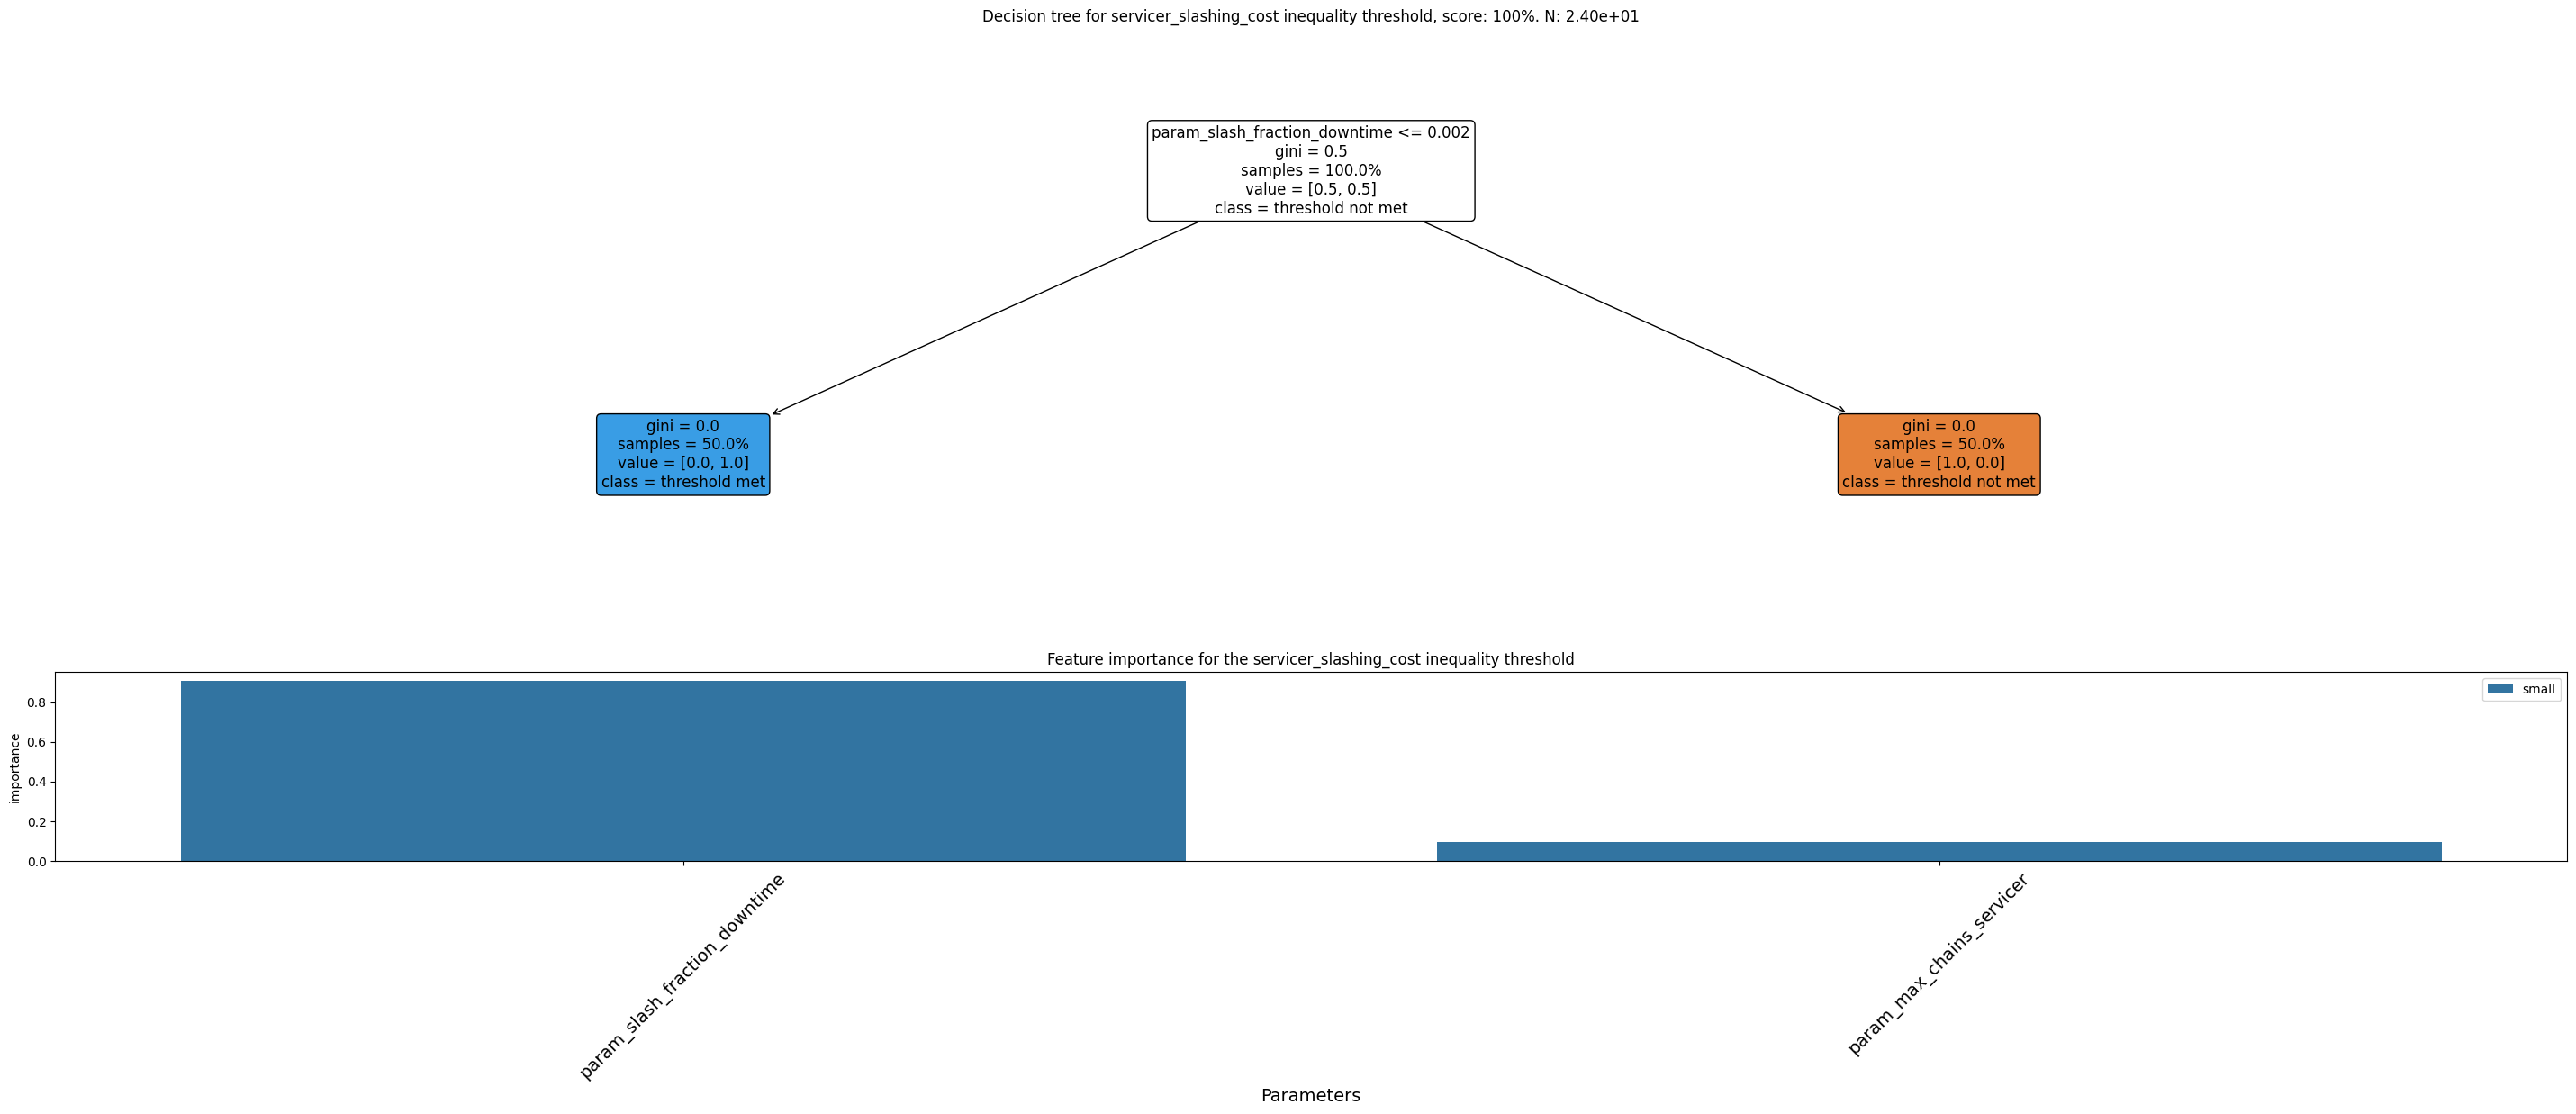

In [7]:
decision_tree_feature_importance_plot(scenario_sweep_category)

# Parameter Impact on KPIs

The simulation results provide, for each combination of swept protocol parameter values ("parameter constellations"), a series of outcomes distinguished by different random realizations of stochastic ("Monte Carlo") distributions. Thus, each of the KPIs can be computed for each simulation result, and a _frequency distribution_ or _density_ of KPI values can be generated for each of the iterations of the adaptive grid approach. These densities can be further broken down by protocol parameter value, and the changes in the densities across different values can be visualized. This provides a method of assessing the sensitivity of the KPIs to the protocol parameters, both at the initial adaptive grid implementation, before optimization is performed, and at the end of the implementation, when the recommended parameter ranges have been achieved.

Each group of figures below corresponds to one of the protocol parameters. Each row in a figure group corresponds to a different KPI, and each column to the initial adaptive grid and final adaptive grid simulation results. Within a figure, the density corresponding to each swept value of the associated protocol parameter is presented (generally, the lower sweep value is displayed in blue, while the upper sweep value is in red, although this may not always be the case). 

By examining the changes in the shape of the KPI densities across sweep values and across the adaptive grid results, a qualitative visual assessment of how sensitive the KPI under scrutiny is to the swept protocol parameter can be made.

In [8]:
from psuu.parameter_impact_plots import *
merged_df = read_and_format_data(scenario_sweep_category=scenario_sweep_category)

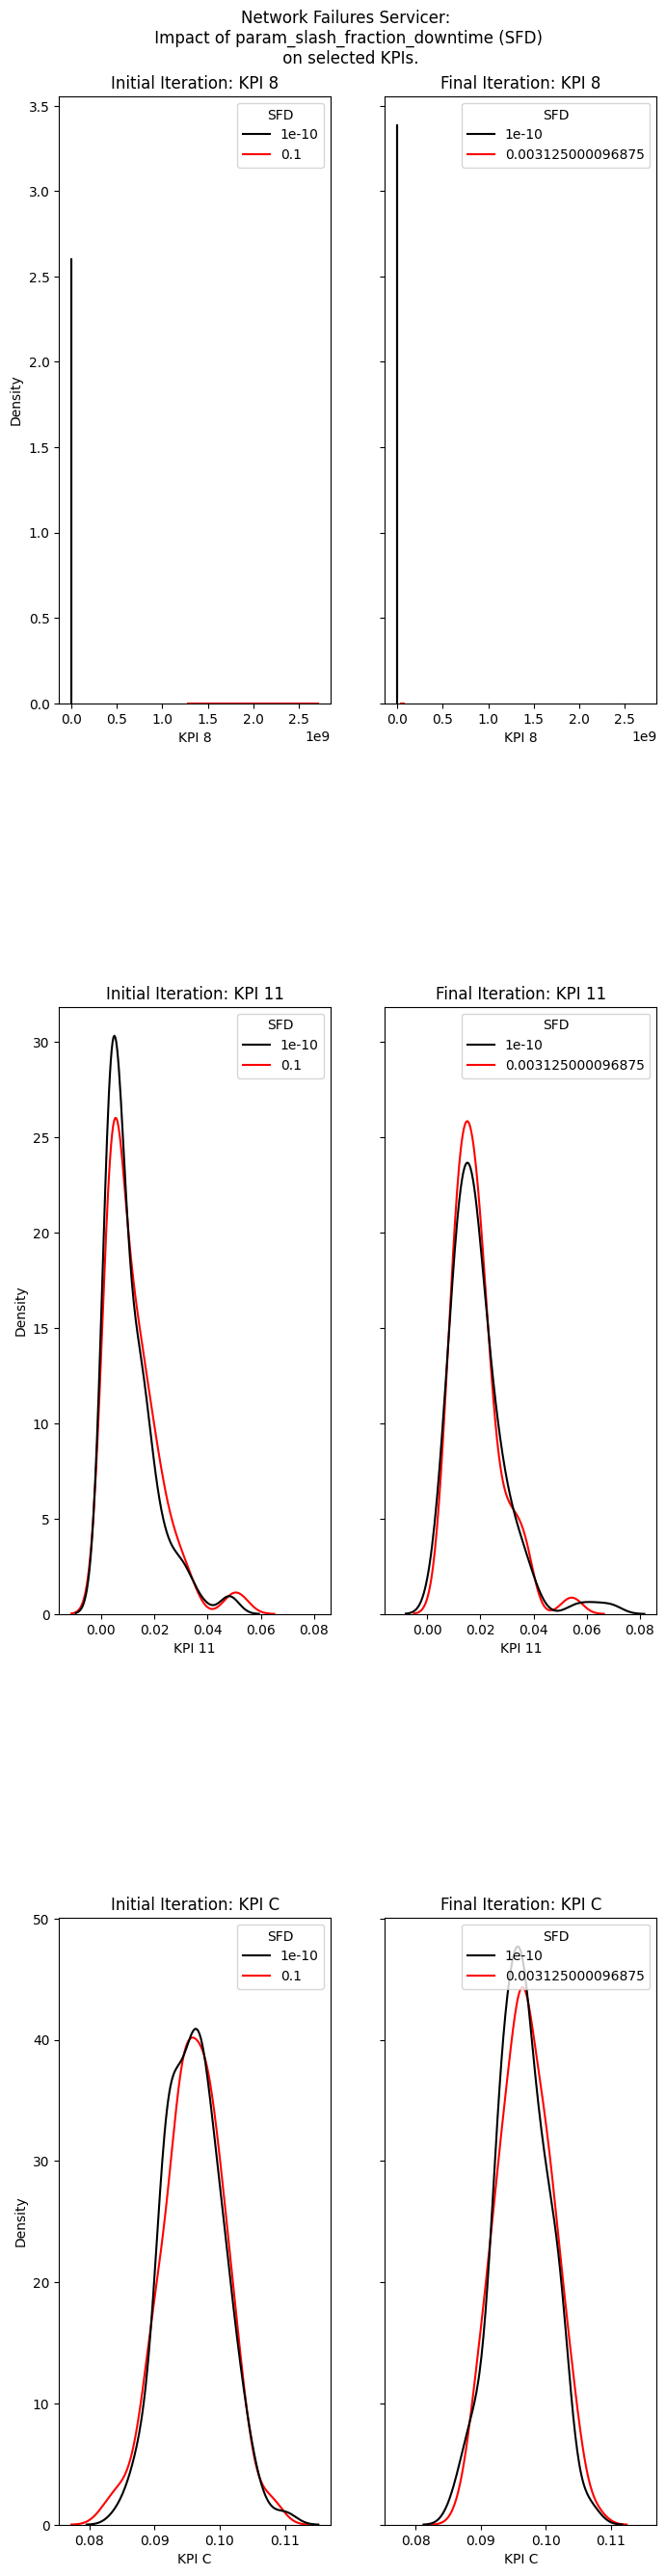

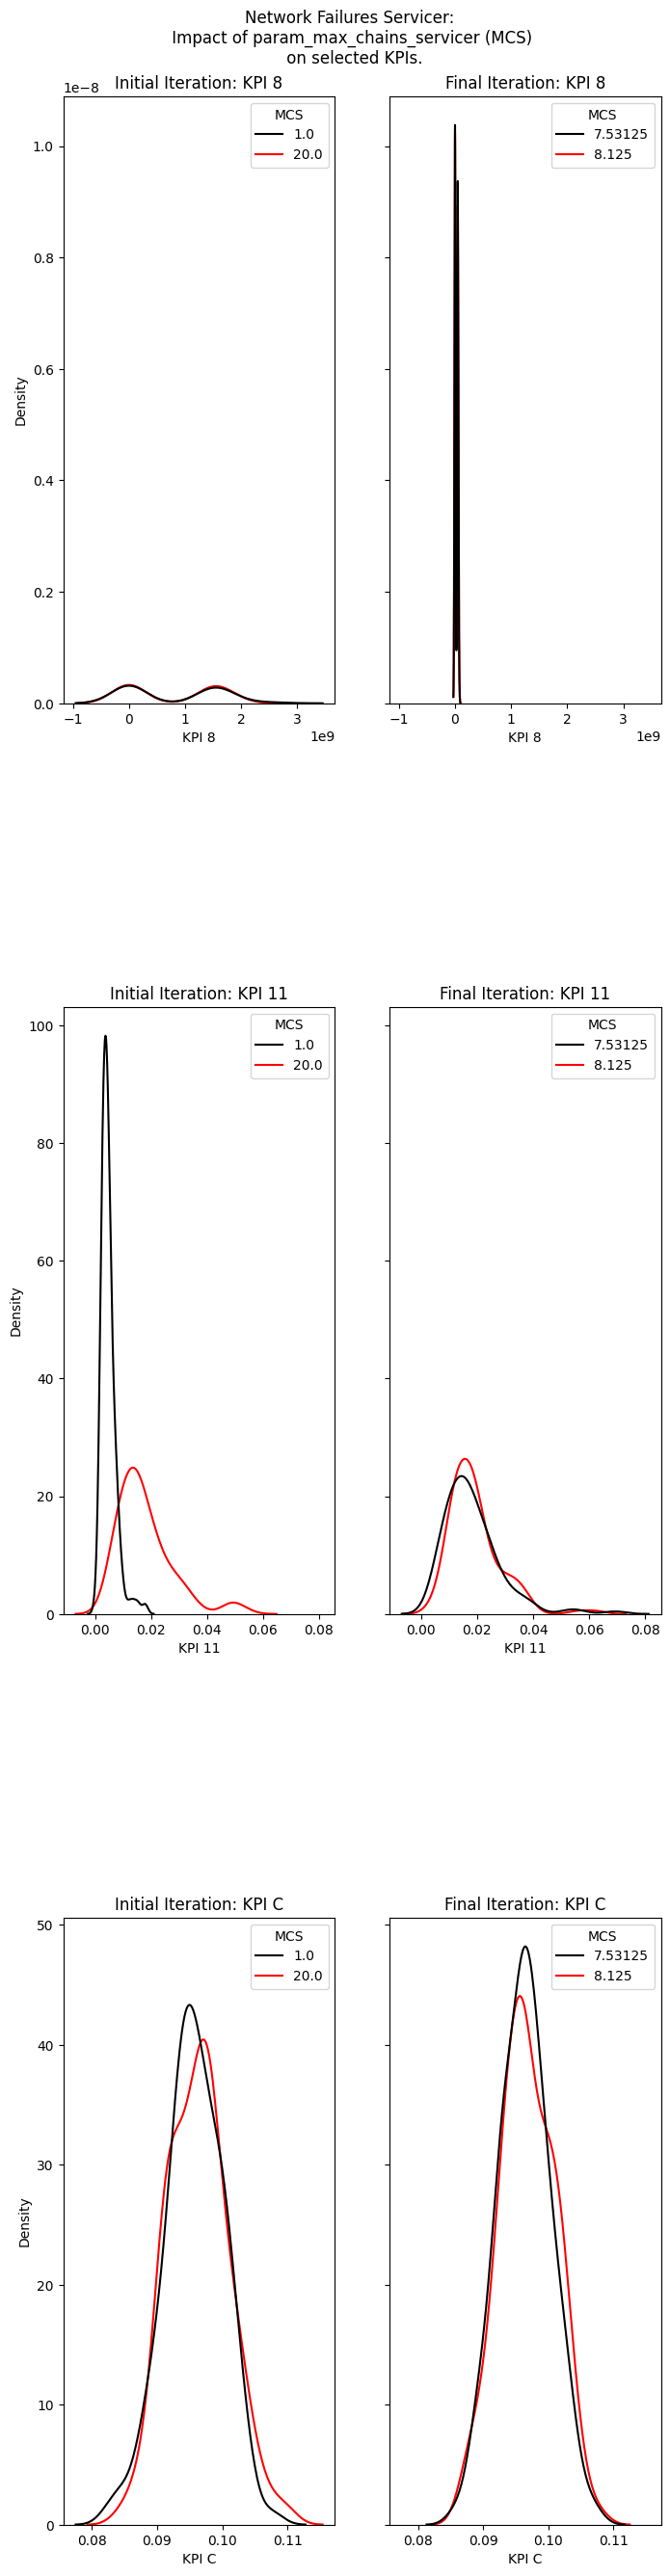

In [9]:
latest_adaptive_grid = max(kpis[scenario_sweep_category])
for param_name in kpis[scenario_sweep_category][latest_adaptive_grid]['variable_params']:
    make_initial_vs_final_plot(df = merged_df,
                           scenario_sweep_category = scenario_sweep_category,
                           param_name = "param_" + param_name, fig_width = 30)

# Conclusion

Unfortunately it is unclear whether this scenario group has provided actionable conclusions regarding the parameter ranges recommended above. Of the threshold inequalities only the **Servicer Jailing Opportunity Cost** was satisfied, but as this was satisfied for every adaptive grid iteration it is unclear if this simply means that the threshold value for the jailing opportunity cost (1 POKT) is too low. On the other hand, the **Servicer Slashing Cost** was only satisfied for half of the parameter values,  while arguably the most important threshold inequality for these experiments, the **Network Load Balancing** inequality, was not satisfied for any parameter combination.

Since only the **Servicer Slashing Cost** provided enough variation in the threshold inequalities, it is the “driver” for the recommended parameter combinations. The decision tree analysis shows (not surprisingly) that for this threshold inequality the `SFD` parameter is the most important. This is reinforced by the parameter impact plots, where increasing `SFD` reduces the mean and variance of the servicer jailing opportunity cost KPI, while slightly increasing the mean of the network load balancing KPI (recall that this KPI, being the Gini coefficient of the distribution of relay traffic across servicers, is increasing in the ‘inequality’ of the network, i.e. more relay traffic is concentrated in a smaller number of servicers the larger is this value). This implies that increasing the slash fraction in the event of downtime can be detrimental to load balancing. 

The `MCS` parameter, while not contributing to the classification problem of for the **Servicer Slashing Cost** threshold inequality, does impact the servicer jailing opportunity cost KPI (increasing its mean slightly as it increases) as well as the network load balancing KPI (lowering its mean as it increases). Increasing the maximum number of services that a servicer can connect to provides a more equal load balancing across the network, perhaps as to be expected.

From the simulation data there is some evidence that network load balancing recovers to around 75% of its previous value, which is less than the 90% threshold inequality value originally postulated. Thus, it can be that future simulation work may benefit from lowering this value. At the same time, inclusion of the `DJD` (downtime jail duration) parameter in a meaningful sense can also potentially contribute to a deeper understanding of the costs involved of a servicer going ‘offline’, if a way can be found to include this parameter in a simulation with daily fidelity. Finally, the relatively small number of parameters may make this scenario group attractive to a larger grid size for the adaptive grid methodology.